## Website Landing Page EDA, Statistical Analysis and Conversion Prediction

### Description of data  
Source Dataset: https://github.com/jainds/eda-for-conversion-rate-dataset/tree/master  

- "conversion_data" - information about signed-in users during one session. Each row is a user session.
- *country* : user country based on the IP address
- *age* : user age. Self-reported at sign-in step
- *new_user* : whether the user created the account during this session or had already an account and simply came back to the site
- *source* : marketing channel source
    - *Ads*: came to the site by clicking on an advertisement
    - *Seo*: came to the site by clicking on search results
    - *Direct*: came to the site by directly typing the URL on the browser
- *total_pages_visited*: number of total pages visited during the session (proxy for time spent on site and engagement during the session).
- *converted*: this is our label. 1 means they converted within the session, 0 means they left without buying anything.

### Objective
- Conduct an Exploratory Data Analysis (Data cleaning & prep, Uni/Bivariate Analysis, Conversion Rate Analysis)
- Statistical Testing to assess variables impacting Conversion Rate, Relationships among Variables 
- A/B Testing to assess impact of change in Landing Page (using artifically generated experiment vs. control group data)
- Development of an ML Classification model to predict Conversion of User, achieving at least 85% F1 Score.


### Initiation

In [2]:
# Import libraries

# Basic Data Imports
import numpy as np
import pandas as pd
import datetime as dt 

# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Imports for stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binom,spearmanr, chi2_contingency

# Imports for Classification modeling
from sklearn.model_selection import train_test_split


In [3]:
# Import dataset

df_original= pd.read_csv('data/conversion_data.csv')
df_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


- Total 316,200 records, none of the columns have null values.
- No changes needed in data type.

In [5]:
df_original.describe(include= 'all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


Initial Observations:
- Our dataset is derived from 4 countries, with most of the data being from US (more than 50%).
- Average age of visitors is ~ 31 years. Maximum age is 123 years, which looks like an outlier. Will check for outlying values.
- *new_user* being 1 implies they created an account when they visited the website in that instance. Average value of 0.68 indicates generally we might have more new users than old users.
- We have 3 channels identified as source (already defined in data description). ~50% of the visitors are coming from search results, and are in majority.
- Average page visits by users = 4.87. Maximum page visits by a user in a session is 29.
- *converted* would imply sale/conversion in that particular record/session. Average value of 0.0322 implies about 3.22% aggregate conversion rate. 


In [42]:
# Convert String columns as Categorical
cols = ['country', 'source']
df_original[cols] = df_original[cols].astype('category')

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              316200 non-null  category
 1   age                  316200 non-null  int64   
 2   new_user             316200 non-null  int64   
 3   source               316200 non-null  category
 4   total_pages_visited  316200 non-null  int64   
 5   converted            316200 non-null  int64   
dtypes: category(2), int64(4)
memory usage: 10.3 MB


### Exploratory Data Analysis (EDA)
We'll follow the workflow below:
- Data Cleaning & Preparation, Check for missing values, duplicates and outliers.
- *Univariate Analysis*: 
    - Examine distributions of numerical variables (histograms for age, pages visited, etc.).
    - Review frequency counts for categorical variables (country, acquisition channel).
- *Bivariate Analysis*:
    - %age conversion by Country
    - Distribution of age comparison (converted vs. non-converted)
    - Distribution of new user vs. conversion
    - Distribution of page visits comparison (converted vs. non-converted)
- *Deriving Conversion Rate*:
    - Calculate Agg. Conversion Rate (No. of Conversions/Total Sessions)
    - *Segmented rates*: conversion rates by category (e.g., by country, device type).

#### Data Cleaning

In [44]:
# Already checked in DF info that we don't have null values.
# Checking for duplicates

df_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


As the variables contain information about the demographic, marketing channel and general stats, there are likely to be duplications, considering we don't have any Personal Information to differentiate user session by any identity or specific location/time etc.  

Hence in this case, we will not be removing any duplicate records. We have already reviewed under the dataframe info that none of the columns have missing values.

In [48]:
df_original.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

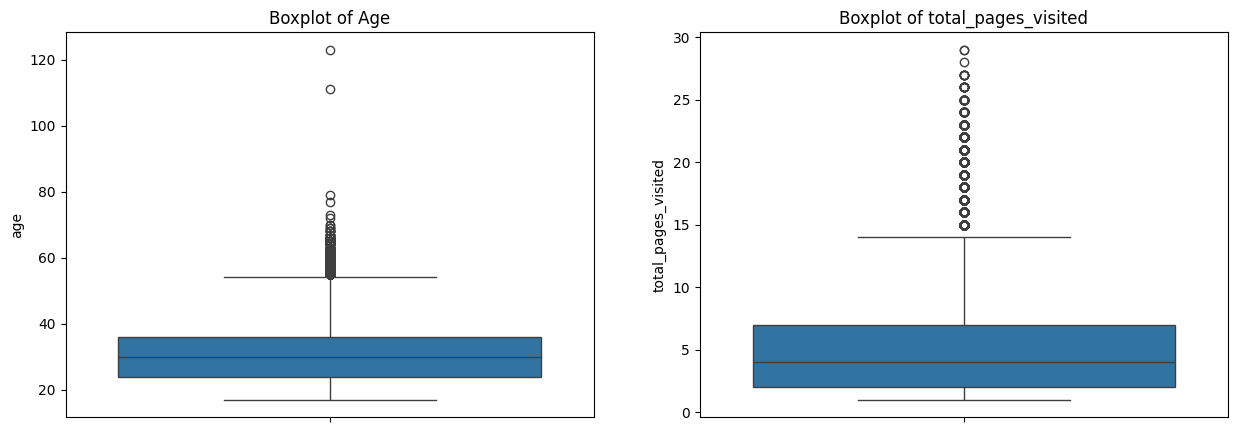

In [49]:
# Plotting boxplot to assess outliers in continuous variables age and total_pages_visited 
fig, axes = plt.subplots(1,2, figsize= (15,5))
ax1= sns.boxplot(df_original['age'],ax= axes[0])
ax1.set_title('Boxplot of Age')

ax2= sns.boxplot(df_original['total_pages_visited'],ax= axes[1])
ax2.set_title('Boxplot of total_pages_visited')

plt.show()

- 'Age' has quite a few extreme outliers. We also have values greater than 100, which we'll look into. Outliers might need to be dealt with for some modeling uses.
- 'total_pages_visited' is less skewed and there are some outlying values.
- We'll consider necessary action based on future needs.

In [50]:
df_original[df_original['age'] >100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [51]:
df_original.sort_values(by= ['age'], ascending= False).head()

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0


There are 2 sessions, wherein the visitor age is above 100, which seems an erroneous value. As these are just 2 session records, we'll leave them as it is, given it wouldn't impact much.

In [52]:
# Creating a derived DF with renamed columns for simplicity
df_edit= df_original.rename(columns= {'total_pages_visited':'page_visits', 'source':'channel'})
df_edit.head()

,country,age,new_user,channel,page_visits,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


#### Univariate Analysis 

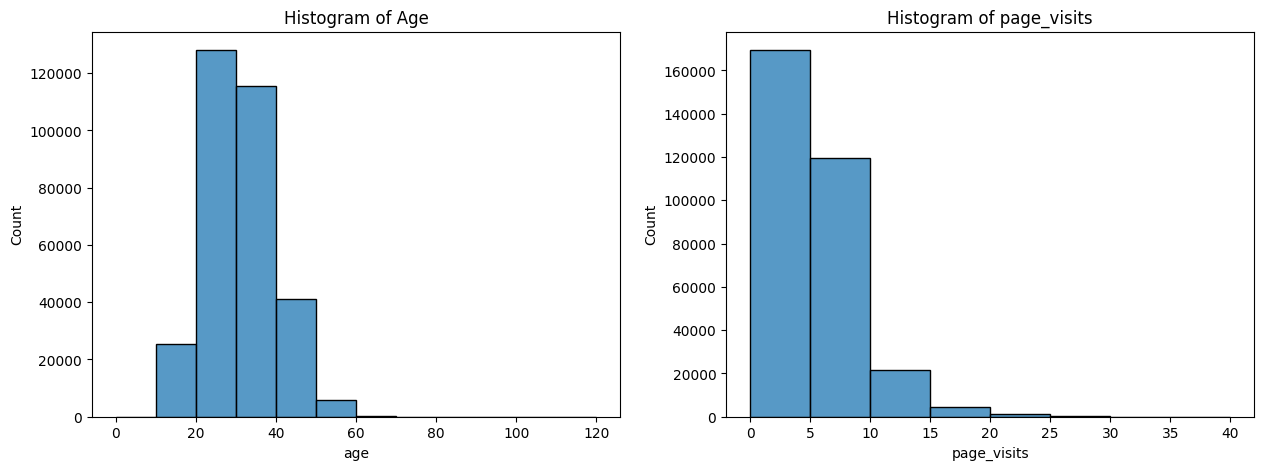

In [53]:
# Plotting histogram to review distribution of discrete variables
fig, axes = plt.subplots(1,2, figsize= (15,5))
ax1= sns.histplot(df_edit['age'], binwidth= 10, binrange= (0,120), ax= axes[0])
ax1.set_title('Histogram of Age')

ax2= sns.histplot(df_edit['page_visits'], binwidth= 5, binrange= (0,40), ax= axes[1])
ax2.set_title('Histogram of page_visits')

plt.show()

In [54]:
# Summary Statistics:
print('Five Number Summary - Age:-')
print('Minimum age:', df_edit['age'].min())
print('Lower Quartile:', df_edit['age'].quantile(0.25))
print('Median:', df_edit['age'].median())
print('Upper Quartile:', df_edit['age'].quantile(0.75))
print('Maximum age:', df_edit['age'].max())

print()
print('Five Number Summary - page_visits:-')
print('Minimum visits:', df_edit['page_visits'].min())
print('Lower Quartile:', df_edit['page_visits'].quantile(0.25))
print('Median:', df_edit['page_visits'].median())
print('Upper Quartile:', df_edit['page_visits'].quantile(0.75))
print('Maximum visits:', df_edit['page_visits'].max())


Five Number Summary - Age:-
Minimum age: 17
Lower Quartile: 24.0
Median: 30.0
Upper Quartile: 36.0
Maximum age: 123

Five Number Summary - page_visits:-
Minimum visits: 1
Lower Quartile: 2.0
Median: 4.0
Upper Quartile: 7.0
Maximum visits: 29


- Most visitors are between the age of 20-30 (more than 120K). 
- Most visitors are viewing between 0-5 pages on the website.
- Most visitors are aged 30 and visit 4 pages.
- Both distributions are skewed to the right.

In [55]:
# Review frequency counts for categorical variables (country, acquisition channel)

print(df_edit['country'].value_counts())
print()
print(df_edit['new_user'].value_counts())
print()
print(df_edit['channel'].value_counts())
print()
print(df_edit['converted'].value_counts())

country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

new_user
1    216744
0     99456
Name: count, dtype: int64

channel
Seo       155040
Ads        88740
Direct     72420
Name: count, dtype: int64

converted
0    306000
1     10200
Name: count, dtype: int64


For our target variable, we have ~3% values as converted. There is a high *Class Imbalance* here, and if we do not get satisfactory performance from our models, we may try *Class Balancing*.

#### Bivariate Analysis

##### Correlation between discrete variables

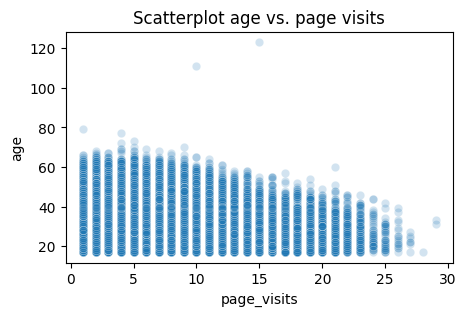

In [56]:
# Check correlation for numeric features (Age/Pages visited).
plt.figure(figsize= (5,3))
sns.scatterplot(y= df_edit['age'], x= df_edit['page_visits'], alpha= 0.2)
plt.title('Scatterplot age vs. page visits')
plt.show()

In [57]:
# Calculate Spearman's rank coefficient and p-value

rho, p_val = spearmanr(df_edit['age'],df_edit['page_visits'])

print("Spearman's rank correlation coefficient:", rho)
print("P-value:", p_val)

Spearman's rank correlation coefficient: -0.02610222876782161
P-value: 8.638578755890443e-49


There is almost no correlation between age and page visits. The statistical significance might be due to the large sample size.

##### Comparison by Market

In [58]:
# Comparison of Average and Std. Deviation of Age, New User, Page Visits and Conversion by Country
df_edit.groupby(['country'])[['age','new_user','page_visits','converted']].agg(['mean','std']).style.background_gradient()

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\1697841430.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_edit.groupby(['country'])[['age','new_user','page_visits','converted']].agg(['mean','std']).style.background_gradient()


In [59]:
df_edit['country'].value_counts()

country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

*Observations*:
- Average age and distribution of website visitors is comparable across the 4 markets.
- *China*: Has highest %age of new users (69.85%), but the lowest conversion ratio (0.13%) and avg. page visits (4.55). They also have the second highest no. of sessions after US, so it might have a lot of potential and might be worth looking into. 
- *Germany*: Has lowest %age of new users (67.72%), but highest on avg. page visits and conversion ratio (~6.25%). It seems users are interested, but the low total no. of sessions suggest it might take some time to gather significance compared to other markets.

In [60]:
# Comparison of Sessions via Channels by Country
ctrychan_pivot= df_edit.pivot_table(index= 'country', columns= 'channel', aggfunc= 'size', fill_value= 0)
ctrychan_pivot['Ads_Cum'] = round((ctrychan_pivot['Ads']/(ctrychan_pivot['Ads'] + ctrychan_pivot['Direct'] + ctrychan_pivot['Seo']))*100,2)
ctrychan_pivot['Direct_Cum'] = round((ctrychan_pivot['Direct']/(ctrychan_pivot['Ads'] + ctrychan_pivot['Direct'] + ctrychan_pivot['Seo']))*100,2)
ctrychan_pivot['Seo_Cum'] = round((ctrychan_pivot['Seo']/(ctrychan_pivot['Ads'] + ctrychan_pivot['Direct'] + ctrychan_pivot['Seo']))*100,2)
ctrychan_pivot

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\2066476580.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ctrychan_pivot= df_edit.pivot_table(index= 'country', columns= 'channel', aggfunc= 'size', fill_value= 0)


channel,Ads,Direct,Seo,Ads_Cum,Direct_Cum,Seo_Cum
country,,,,,,
China,21561,17463,37578,28.15,22.80,49.06
Germany,3760,2864,6432,28.80,21.94,49.26
UK,13518,11131,23801,27.90,22.97,49.12
US,49901,40962,87229,28.02,23.00,48.98


- The 3 columns 'Ads_Cum', 'Direct_Cum' and 'Seo_Cum' represent the cumulative percentage usage of a channel via which the session was reached from a particular country.
- Channel usage distribution seems mostly similar:
    - UK has slightly lower %age of users coming via Ads, compared to other countries which achieve 28% min.
    - US has most sessions generated via 'Direct' channel (indicating offline user awareness).
    - Germany leads to the highest sessions via search engine.

##### Comparison by Age

In [61]:
# Categorize age for assessment
age_review= df_edit.copy()
age_review['age_bracket'] = pd.qcut(age_review['age'],4,labels= ['Low', 'Medium','High','Very High'])
age_review.head(10)

,country,age,new_user,channel,page_visits,converted,age_bracket
0,UK,25,1,Ads,1,0,Medium
1,US,23,1,Seo,5,0,Low
2,US,28,1,Seo,4,0,Medium
3,China,39,1,Seo,5,0,Very High
4,US,30,1,Seo,6,0,Medium
5,US,31,0,Seo,1,0,High
6,China,27,1,Seo,4,0,Medium
7,US,23,0,Ads,4,0,Low
8,UK,29,0,Direct,4,0,Medium
9,US,25,0,Ads,2,0,Medium


In [62]:
# Check Age Bracket Definitions
print('Min. age in Low bracket:', age_review[age_review['age_bracket'] == 'Low'][['age']].min())
print('Max. age in Low bracket:', age_review[age_review['age_bracket'] == 'Low'][['age']].max())
print()
print('Min. age in Medium bracket:', age_review[age_review['age_bracket'] == 'Medium'][['age']].min())
print('Max. age in Medium bracket:', age_review[age_review['age_bracket'] == 'Medium'][['age']].max())
print()
print('Min. age in High bracket:', age_review[age_review['age_bracket'] == 'High'][['age']].min())
print('Max. age in High bracket:', age_review[age_review['age_bracket'] == 'High'][['age']].max())
print()
print('Min. age in Very High bracket:', age_review[age_review['age_bracket'] == 'Very High'][['age']].min())
print('Max. age in Very High bracket:', age_review[age_review['age_bracket'] == 'Very High'][['age']].max())

Min. age in Low bracket: age    17
dtype: int64
Max. age in Low bracket: age    24
dtype: int64

Min. age in Medium bracket: age    25
dtype: int64
Max. age in Medium bracket: age    30
dtype: int64

Min. age in High bracket: age    31
dtype: int64
Max. age in High bracket: age    36
dtype: int64

Min. age in Very High bracket: age    37
dtype: int64
Max. age in Very High bracket: age    123
dtype: int64


In [63]:
# Comparison of Average and Std. Deviation of New User, Page Visits and Conversion by Age
age_review.groupby(['age_bracket'])[['new_user','page_visits','converted']].agg(['mean','std']).style.background_gradient()

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\3302971934.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_review.groupby(['age_bracket'])[['new_user','page_visits','converted']].agg(['mean','std']).style.background_gradient()


- We have the highest %age of new users in the 'Very High' age bracket (37+ years old), i.e. 69.26%. However, the conversion rate is the least 1.31%.
- Highest conversion rate of 5.53% is observed for 'Low' age bracket users (17 - 24 years old). However, %age of new users is slightly lower. 
- Page visits generally range between 4-5 for each age category, it being lower for higher ages.


In [64]:
# Comparison of Sessions via Channels by Age
agechan_pivot= age_review.pivot_table(index= 'age_bracket', columns= 'channel', aggfunc= 'size', fill_value= 0)
agechan_pivot['Ads_Cum'] = round((agechan_pivot['Ads']/(agechan_pivot['Ads'] + agechan_pivot['Direct'] + agechan_pivot['Seo']))*100,2)
agechan_pivot['Direct_Cum'] = round((agechan_pivot['Direct']/(agechan_pivot['Ads'] + agechan_pivot['Direct'] + agechan_pivot['Seo']))*100,2)
agechan_pivot['Seo_Cum'] = round((agechan_pivot['Seo']/(agechan_pivot['Ads'] + agechan_pivot['Direct'] + agechan_pivot['Seo']))*100,2)
agechan_pivot

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\1986159707.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  agechan_pivot= age_review.pivot_table(index= 'age_bracket', columns= 'channel', aggfunc= 'size', fill_value= 0)


channel,Ads,Direct,Seo,Ads_Cum,Direct_Cum,Seo_Cum
age_bracket,,,,,,
Low,23498,19143,40890,28.13,22.92,48.95
Medium,23715,19311,41294,28.12,22.90,48.97
High,20936,17031,36221,28.22,22.96,48.82
Very High,20591,16935,36635,27.77,22.84,49.40


- The 3 columns 'Ads_Cum', 'Direct_Cum' and 'Seo_Cum' represent the cumulative percentage usage of a channel via which the session was reached for a particular age bracket.
- Generally, we find a similar distribution of channel usage with highest sessions created from Search Engines (~49%), and lowest from Direct channel (~23%).
    - For 'Very High' age group, %age share of sessions from Ads is slightly lower at 27.77%, compared to other age groups which achieve min. of 28%. For this age group, search engine sessions are relatively higher.

##### Comparison by User Type

In [65]:
# Comparison of Average and Std. Deviation of Page Visits and Conversion by New Users
df_edit.groupby(['new_user'])[['page_visits','converted']].agg(['mean','std']).style.background_gradient()


In [66]:
df_edit['new_user'].value_counts(normalize= True)* 100

new_user
1    68.54649
0    31.45351
Name: proportion, dtype: float64

- For existing users, we have higher avg. page visits and %age conversion of 7.20%. However, majority of users are new (68.55%).

In [67]:
# Comparison of Sessions via Channels by New User
userchan_pivot= df_edit.pivot_table(index= 'new_user', columns= 'channel', aggfunc= 'size', fill_value= 0)
userchan_pivot['Ads_Cum'] = round((userchan_pivot['Ads']/(userchan_pivot['Ads'] + userchan_pivot['Direct'] + userchan_pivot['Seo']))*100,2)
userchan_pivot['Direct_Cum'] = round((userchan_pivot['Direct']/(userchan_pivot['Ads'] + userchan_pivot['Direct'] + userchan_pivot['Seo']))*100,2)
userchan_pivot['Seo_Cum'] = round((userchan_pivot['Seo']/(userchan_pivot['Ads'] + userchan_pivot['Direct'] + userchan_pivot['Seo']))*100,2)
userchan_pivot

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\2061111451.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  userchan_pivot= df_edit.pivot_table(index= 'new_user', columns= 'channel', aggfunc= 'size', fill_value= 0)


channel,Ads,Direct,Seo,Ads_Cum,Direct_Cum,Seo_Cum
new_user,,,,,,
0,27891,22678,48887,28.04,22.80,49.15
1,60849,49742,106153,28.07,22.95,48.98


- Distribution of channel usage is mostly similar across new or old user.
- Search engine based sessions are slightly higher than other channels for existing users. Mostly expected as existing users must be searching for the website to go to it, compared to new users who come via Ads or Direct.

##### Comparison by Channel

In [68]:
# Comparison of Average and Std. Deviation of Page Visits and Conversion by Channel
df_edit.groupby(['channel'])[['page_visits','converted']].agg(['mean','std']).style.background_gradient()

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\4040609424.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_edit.groupby(['channel'])[['page_visits','converted']].agg(['mean','std']).style.background_gradient()


- User sessions generated based on Direct channels generally have lower page visits on average and a lower %age conversion (2.82%).

#### Conversion Rates

Conversion Rate = (Total Converted Sessions) / (Total Sessions)

Total Converted Sessions --> converted = 1

In [69]:
# Aggregate Conversion Rate
print('Aggregate Conversion Rate based on Session Data:', '{:.3f}%'.format(df_edit['converted'].mean() * 100))

Aggregate Conversion Rate based on Session Data: 3.226%


In [70]:
# Conversion Rates by country
round(df_edit.groupby(['country'])[['converted']].mean()* 100,2)

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\2179725047.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round(df_edit.groupby(['country'])[['converted']].mean()* 100,2)


,converted
country,
China,0.13
Germany,6.25
UK,5.26
US,3.78


In [71]:
# Conversion Rates by user type
round(df_edit.groupby(['new_user'])[['converted']].mean()* 100,2)

,converted
new_user,
0,7.2
1,1.4


In [72]:
# Conversion Rates by Age Bracket
round(age_review.groupby(['age_bracket'])[['converted']].mean()* 100,2)

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\2440132702.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round(age_review.groupby(['age_bracket'])[['converted']].mean()* 100,2)


,converted
age_bracket,
Low,5.54
Medium,3.45
High,2.28
Very High,1.31


In [73]:
# Conversion Rates by Channel
round(df_edit.groupby(['channel'])[['converted']].mean()* 100,2)

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\1740947846.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round(df_edit.groupby(['channel'])[['converted']].mean()* 100,2)


,converted
channel,
Ads,3.45
Direct,2.82
Seo,3.29


- We observe that there is significant variance in conversion rate based on Market, User type and Age, which might be useful predictor variables while modeling.

#### Summary of Observations

1. We have 2 numeric discrete variables (age, total_pages_visited), 2 categorical finite variables (country, source) and 2 categorical boolean variables (new_user, converted)
2. Based on the variables provided, there are likely to be duplicates and it would not be wrong to have them. Hence we are not removing any duplicates. No Null values were found.
3.  Numeric variables age aand total_pages_visited have outliers, age having the most outliers. Two sessions have age > 100, which seems unlikely. The outliers for now haven't been addressed, and would be treated as necessary at the modeling stage.
4. Columns were renamed from total_pages_visited to page_visits and source to channel, for accurate representation and brevity.
5. **Univariate Analysis**:
    - Distribution of numeric variables age and page_visits are both skewed to the right. 
    - Most visitors are aged 30 and visit 4 pages.
    - For our target variable (converted), we have ~3% values as converted. There is a high *Class Imbalance*, and if we might not be getting good prediction from our model, we might consider balancing.
6. **Bivariate Analysis**:
    - There is almost no correlation between age and page visits.
    - *Comparison by Markets*:
        - *China*: Has highest %age of new users (69.85%), but the lowest conversion ratio (0.13%) and avg. page visits (4.55). They also have the second highest no. of sessions after US, so it might have a lot of potential and might be worth looking into. 
        - *Germany*: Has lowest %age of new users (67.72%), but highest on avg. page visits and conversion ratio (~6.25%). It seems users are interested, but the low total no. of sessions suggest it might take some time to gather significance compared to other markets.
        - Channel usage distribution seems mostly similar across markets.
    - *Comparison by Age*:
        - We have the highest %age of new users in the 'Very High' age bracket (37+ years old), i.e. 69.26%. However, the conversion rate is the least 1.31%.
        - Highest conversion rate of 5.53% is observed for 'Low' age bracket users (17 - 24 years old). However, %age of new users is slightly lower. 
        - Page visits generally range between 4-5 for each age category, it being lower for higher ages.
        - we find a similar distribution of channel usage across different age brackets.
    - *Comparison by User Type*:
        - For existing users, we have higher avg. page visits and %age conversion of 7.20%. However, majority of users are new (68.55%).
        - Distribution of channel usage is mostly similar across new or old user.
    - *Comparison by Channel*:
        - User sessions generated based on Direct channels generally have lower page visits on average and a lower %age conversion (2.82%).
7. **Conversion Rates**:
    - Aggregate Conversion Rate based on Session Data: 3.226%
    - Variance in conversion rates by Market:
        - Highest: Germany (6.25%)
        - Lowest: China (0.13%)
    - Variance in conversion rates by User Type:
        - Highest: Existing users (7.20%)
        - Lowest: China (1.40%)

### Statistical Testing
We'll follow the workflow below:
- *Chi-Square Test for Independence*
    - Does Conversion get impacted by Market
    - Does Conversion get impacted by Marketing Channel
- A/B Testing Simulation
    - Add variable for new page vs. old page (fictional)
    - Two sample test of Mean for performance of new v.s. old page

#### Chi-Square Test for Independence (Stat. Significance)

In [74]:
# Function to conduct Chi-Square Test of Independence
def chi_test(data, col1, conv):
    ''' 
    Intended to setup contingency table and conduct Chi-Square test for independence to determine if we can reject the null hypothesis, 
    that the conversion rate is not impacted by the categorical variable. Function returns the p-value as output.
    Arguments:
    data: Name of Dataframe
    col1: categorical variable name
    conv: Column referring to session conversion 
    '''
    cont_table= data.pivot_table(index= col1, columns= conv, aggfunc= 'size', fill_value= 0)
    cont_table= cont_table.to_numpy()
    result= chi2_contingency(cont_table, correction= False)[1]
    return result

In [75]:
print('p-value Chi Square Test for Market:', chi_test(df_edit,'country','converted'))
print('p-value Chi Square Test for Channel:', chi_test(df_edit,'channel','converted'))

C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\4060730128.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cont_table= data.pivot_table(index= col1, columns= conv, aggfunc= 'size', fill_value= 0)
C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_27464\4060730128.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cont_table= data.pivot_table(index= col1, columns= conv, aggfunc= 'size', fill_value= 0)


p-value Chi Square Test for Market: 0.0
p-value Chi Square Test for Channel: 1.2160321383469431e-12


Based on the p-value of the above tests, we can claim that session conversion is definitely influenced by the Market and Channel of promotion, as explained by statistical check on the sample data.

#### A/B Testing Simulation

In [76]:
df_edit.head()

,country,age,new_user,channel,page_visits,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [77]:
df_edit.shape

(316200, 6)

Within our sample data, we do not have an identifier for an upgraded landing page, as well as a date column. To simulate a hypothetical A/B test, we'll split the dataset into 2 parts randomly using train_test_split (though it is usually used for ML Testing).
- 70% of the data considered previous to landing page changes.
- 30% of the data considered post landing page changes.

In [78]:
# Train test splitting the data to generate A/B test samples 
y = df_edit['converted']
X= df_edit.drop(columns= ['converted'])

XAB_train, XAB_test, yAB_train, yAB_test= train_test_split(X,y, test_size= 0.3, random_state= 100)

In [79]:
# Group A sample (Control group)
A_sample= pd.concat([XAB_train,yAB_train],axis=1)
A_sample.head()

,country,age,new_user,channel,page_visits,converted
167241,US,34,1,Seo,4,0
240238,US,36,1,Seo,2,0
276075,UK,31,1,Direct,6,0
163394,US,34,0,Seo,6,0
116722,Germany,33,1,Seo,6,0


In [ ]:
# Sample A conversion rate
print('A-sample conversion rate:','{:.2f}%'.format(A_sample['converted'].mean() * 100))

A-sample conversion rate: 3.17%


In [ ]:
# Binomial Distribution of Binary 'converted' variable in Control Group
nA= A_sample.shape[0]
pA= A_sample['converted'].sum()/n

x_min= int(binom.ppf(0.001,nA,pA))
x_max= int(binom.ppf(0.999,nA,pA))

x= np.arange(x_min, x_max)

pmf= binom.pmf(x,nA,pA)
plt.figure(figsize= (8,4))
plt.bar(x, pmf)
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.title(f'Binomial Distribution (n={nA}, p={pA})')
plt.show()


NameError: name 'n' is not defined

In [ ]:
# Group B sample (Treatment group)
B_sample= pd.concat([XAB_test,yAB_test],axis=1)
B_sample.head()

,country,age,new_user,channel,page_visits,converted
23915,US,46,1,Seo,4,0
60991,US,42,1,Ads,6,0
69351,China,31,1,Seo,7,0
111300,US,39,1,Ads,3,0
146166,China,30,1,Seo,4,0


In [ ]:
# Sample B conversion rate
print('B-sample conversion rate:','{:.3f}%'.format(B_sample['converted'].mean() * 100))

B-sample conversion rate: 3.354%


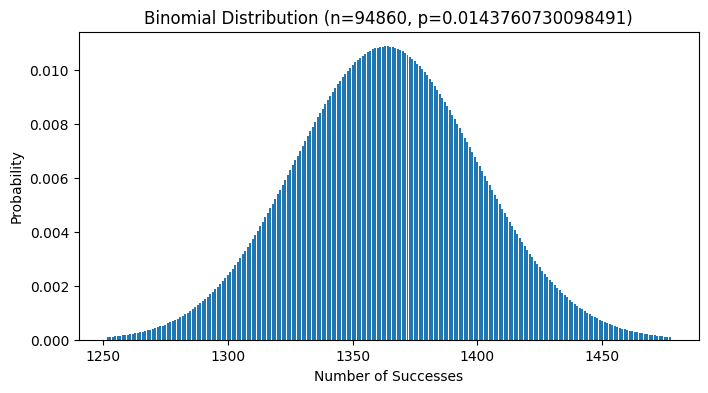

In [ ]:
# Binomial Distribution of Binary 'converted' variable in Treatment group
nB= B_sample.shape[0]
pB= B_sample['converted'].sum()/n

x_min= int(binom.ppf(0.001,nB,pB))
x_max= int(binom.ppf(0.999,nB,pB))

x= np.arange(x_min, x_max)

pmf= binom.pmf(x,nB,pB)
plt.figure(figsize= (8,4))
plt.bar(x, pmf)
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.title(f'Binomial Distribution (n={nB}, p={pB})')
plt.show()


In [ ]:
# Random sampling from both Treatment and Control group

ctrl_sample= A_sample.sample(n= 20000, random_state= 46)
tmnt_sample= B_sample.sample(n= 20000, random_state= 46)

ctrl_sample['test_grp']= 'control'
tmnt_sample['test_grp']= 'treatment'

sample_test= pd.concat([ctrl_sample,tmnt_sample], ignore_index= True)
sample_test.head()

,country,age,new_user,channel,page_visits,converted,test_grp
0,US,26,0,Ads,8,0,control
1,US,23,0,Direct,3,0,control
2,US,39,0,Seo,9,0,control
3,US,32,1,Seo,3,0,control
4,US,42,0,Direct,8,0,control


In [ ]:
sample_test_agg= sample_test.groupby(['test_grp']).agg({'converted':'sum','country':'count'})
sample_test_agg['proportion']= sample_test_agg['converted']/sample_test_agg['country']
sample_test_agg

,converted,country,proportion
test_grp,,,
control,656,20000,0.03280
treatment,673,20000,0.03365


In [ ]:
number_of_successes= [656,673]
total_sample_sizes= [20000,20000]

test_stat, p_value= proportions_ztest(number_of_successes,total_sample_sizes)
p_value

np.float64(0.635308883695795)

### Develop Machine Learning Classification Model
We'll follow the workflow below:
- Identify relevant variables for modeling based on Stats Testing.
- Design classification models using:
    - Logistic Regression
    - Naive Bayes
    - Random Forest with Cross Validation
    - XGBoost with Cross Validation
- Model Tuning and EDA




### Final Assessment, Summary and Recommendations